In [1]:
#
# SET THESE PARAMETERS
#
timei = 2.5
n_cp = 50
#mtype = "fullyconnected"
mtype = "recurrent"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import netCDF4 as nc4
from pathlib import Path
from matplotlib import rc
from matplotlib import gridspec
import time

from bsplinenet.net import Net, LightningNet
from bsplinenet.ff_net import ODESYS
from quadrotor.ellipsoid import gen_ic_ellips
from bsplinenet.Bspline_functions import (Bs_comp, BsKnots, duffing_sys,
                                leastSquaresInversion, rotate)
rc('text', usetex=True)

In [3]:
#
# Defaults for quadrotor_v1 - We assume these have not changed
#

# default range of 12-D sphere
max_x = 2 # m
max_dx = 2 # m/s
max_ag = np.pi/4 # radians
max_da = 5 # rad/sec

R = np.array([max_dx,max_x,
              max_dx,max_x,
              max_dx,max_x,
              max_da,max_ag,
              max_da,max_ag,
              max_da,max_ag])


In [4]:
#
# Load Data
#
data_path = "/home/hspn-user/data/quadrotor_v1/"
data = nc4.Dataset(list(Path(data_path).glob(f"data__quadrotor_3_12_1-100_{int(timei*10)}-10_{n_cp}_1000*.nc"))[0])

time_interval     = data.getncattr('time_interval')
sampling_interval = data.getncattr('sampling_interval')
n_control         = data.getncattr('n_control')
n_dim             = data.getncattr('n_state_dimension')
n_ic              = data.getncattr('n_initial_conditions')
bspline_order     = data.getncattr('bspline_order')


assert(n_control == n_cp)
assert(n_dim == 12)
assert(time_interval== timei)


In [5]:
#
# Load Models
#
model_path = "/home/hspn-user/models/quadrotor_v1/"
fcnn_path = [i for i in Path(model_path).glob(f"quadrotor_v1_{mtype}_ncp={n_cp}_t={timei}_*val_loss=0.000*.ckpt")]
fcnn_mods =[LightningNet.load_from_checkpoint(i).to('cpu') for i in fcnn_path]

n_models = len(fcnn_mods)
print(f' There are {n_models} models of this type')

get_loss = lambda i: torch.load(i)['callbacks']["EarlyStopping{'monitor': 'val_loss', 'mode': 'min'}"]['best_score'].detach().cpu().numpy() 
validationLosses =[ get_loss(i) for i in fcnn_path]
print(f' The mean validation loss is {np.mean(validationLosses)} +/-  {np.std(validationLosses)}')


n_parameters = np.sum([i.numel() for i in fcnn_mods[0].parameters()])
print(f' The number of trainable parameters is {n_parameters}')

/home/hspn-user/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.


 There are 10 models of this type
 The mean validation loss is 2.852571014955174e-06 +/-  5.864893637408386e-07
 The number of trainable parameters is 78732


In [6]:
# get the true initial condition and control points
ic = data['X'][:].data
cp_true = data['Y'][:].data
tr_true = fcnn_mods[0].transform(torch.tensor(data['Y'][:].data)).detach().numpy()

# get the control points and trajectories
cp_pred = np.stack([model(torch.tensor(ic)).detach().numpy() for model in fcnn_mods], axis=-1)
tr_pred = np.stack([model.transform(model(torch.tensor(ic))).detach().numpy() for model in fcnn_mods], axis=-1)

# same for all models
transform_matrix = fcnn_mods[0].transform_matrix

In [7]:
t=[]
test_time_ic =torch.tensor(ic[:1,:]).to('cpu')
for i in range(100):
    start = time.time()
    fcnn_mods[0].to('cpu')(test_time_ic)
    end = time.time()
    if i > 10:
        t.append(end-start)

print(f'Run time is {np.mean(t):2.8f}+/- {np.std(t):2.8f} seconds per initial condition')
print(f'min = {np.min(t)} max= {np.max(t)}')

Run time is 0.02825249+/- 0.00167275 seconds per initial condition
min = 0.025716543197631836 max= 0.033464670181274414


In [8]:
#
# Distance in ball
#

Ric = np.sqrt(np.sum(np.einsum("ij,ij->ij",ic/R,ic/R),axis=1)).reshape(-1,1)

In [9]:
# calculate MSE per cp 
err_cp = np.repeat(cp_true[:,:,np.newaxis],n_models,2) - cp_pred
error2 = err_cp**2

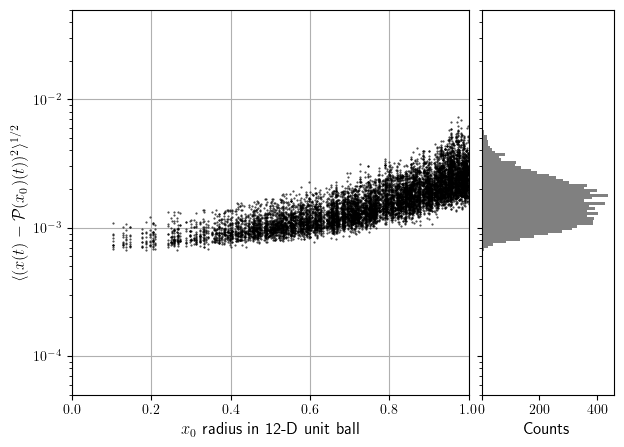

In [10]:
#
# Distance of IC in the 12-D ball versus error in the trajectory
#
rmse = np.sqrt(np.mean(error2,axis=(1))).reshape(-1,n_models)

z = np.hstack([Ric,rmse])

spec = dict(width_ratios=[3, 1], wspace=0.05, hspace=0.05, height_ratios=[1])

fig, ax = plt.subplots(1,2,figsize=(7,5),sharey=True, gridspec_kw=spec)
for i in range(n_models):
    ax[0].plot(z[:,0],z[:,i+1],'k.', markersize=1, alpha=0.8)
    
ax[0].set_xlabel('$x_0$ radius in 12-D unit ball', fontsize = 12)
ax[0].set_ylabel(r'$ \langle(x(t) - \mathcal{P}(x_0)(t))^2\rangle^{1/2}$', fontsize =12);
ax[1].hist( rmse.flatten(),np.logspace(-4,-2,101),orientation='horizontal', color='gray');
ax[1].set_xlabel('Counts', fontsize=12);
ax[0].set_yscale('log')
ax[0].set_ylim(0.00005,0.05)
ax[0].set_xlim(0,1.0001)
ax[0].grid()
plt.savefig(f"RD_distance_vs_MSE_{mtype}.png")

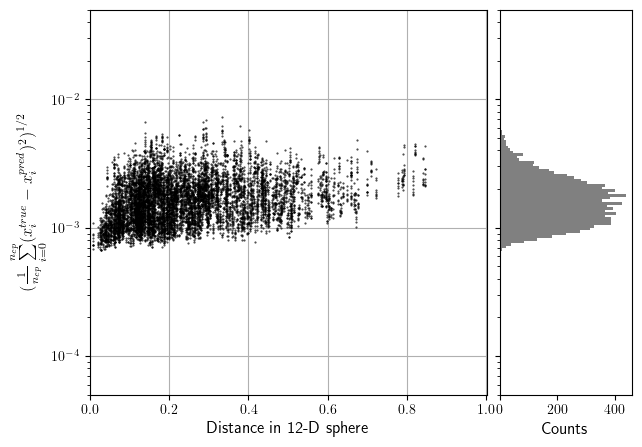

In [11]:
#
# Distance of last in the 12-D ball versus error in the trajectory
#

lp = cp_true[:,49::50]

Rfc = np.sqrt(np.sum(np.einsum("ij,ij->ij",lp/R,lp/R),axis=1)).reshape(-1,1)
z = np.hstack([Rfc,rmse])

spec = dict(width_ratios=[3, 1], wspace=0.05, hspace=0.05, height_ratios=[1])

fig, ax = plt.subplots(1,2,figsize=(7,5),sharey=True, gridspec_kw=spec)
for i in range(n_models-1):
    ax[0].plot(z[:,0],z[:,i+1],'k.', markersize=1, alpha=0.8)
ax[0].set_xlabel('Distance in 12-D sphere', fontsize = 12)
ax[0].set_ylabel(r'$ \big(\frac{1}{n_{cp}}\sum\limits^{n_{cp}}_{i=0} (x_{i}^{true}-x_{i}^{pred})^2\big)^{1/2}$', fontsize =12);
ax[1].hist( rmse.reshape(-1,n_models).flatten(),np.logspace(-4,-2,101),orientation='horizontal', color='gray');
ax[1].set_xlabel('Counts', fontsize=12);
ax[0].set_yscale('log')
ax[0].set_ylim(0.00005,0.05)
ax[0].set_xlim(0,1.0001)
ax[0].grid()
plt.savefig(f"RD_last_distance_vs_MSE_{mtype}.png")

In [12]:
#
# per dimension - how error changes, mostly not informative
#
# z = np.hstack([ic/R, np.mean(error2,axis=(1)).reshape(-1,n_models)])
# spec = dict(width_ratios=[1], wspace=0.2, hspace=0.2, height_ratios=[1]*12)
# fig, ax = plt.subplots(12,1,figsize=(6,21),sharey=True, gridspec_kw=spec)
# for j in range(n_dim):
#    for i in range(n_models):
#        ax[j].plot(z[:,j],z[:,i+n_dim],'k.', markersize=1, alpha=0.57)


(1000, 12, 50, 10) (1000, 12, 50, 10)
(1000, 12, 50, 10) (1000, 12, 50, 10)


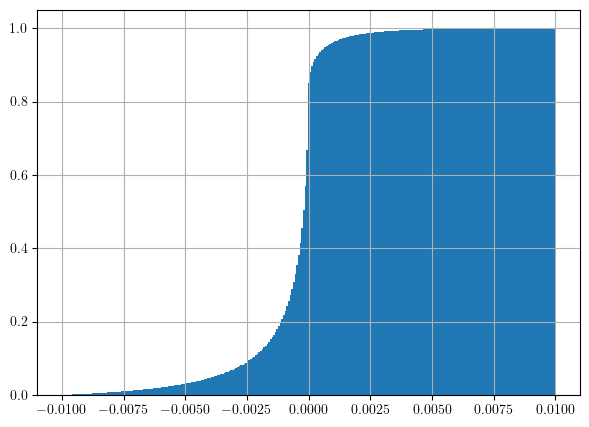

In [13]:
#
# Convex hull calculation
#

# assume same shape as transform matrix 
# use method same as BSKnots
dt_tr = np.arange(0,1,1/transform_matrix.shape[0])
dt_cp = np.arange(0,1,1/transform_matrix.shape[1])
# compute the triangular convex hull (max and min for each dimension)
cpp = cp_pred.reshape(n_ic,n_dim,n_cp,n_models)

even  = cpp[:,:,0::2,:]
odd   = cpp[:,:,1::2,:]
odd_  = np.diff(even,axis=2)/2+even[:,:,:-1,:]
even_ = np.diff(odd,axis=2)/2+odd[:,:,:-1,:]

cp_even = np.stack       ([even[:,:,:-1,:],odd_ ],axis=3).reshape(-1,n_dim,n_cp-2,n_models)
cp_odd  = np.stack       ([odd[:,:,:-1,:] ,even_],axis=3).reshape(-1,n_dim,n_cp-2,n_models)

cp_even = np.concatenate ([cp_even,cpp[:,:,-1:,:],cpp[:,:,-1:,:]], axis=2)
cp_odd  = np.concatenate ([cpp[:,:,:1,:],cp_odd,cpp[:,:,-1:,:]], axis=2)
print(cp_even.shape, cp_odd.shape)

cp_max  = np.max(np.stack([cp_odd, cp_even],axis=4), axis=4)
cp_min  = np.min(np.stack([cp_odd, cp_even],axis=4), axis=4)
print(cp_max.shape, cp_min.shape)

cp_max = cp_max.reshape(n_ic,n_cp*n_dim,n_models)
cp_min = cp_min.reshape(n_ic,n_cp*n_dim,n_models)
cp_true_r = np.repeat(cp_true[:,:, np.newaxis], n_models,2)
# plot difference between upper bound and true trajectory
fig,ax = plt.subplots(1,1, figsize=(7,5))
ax.grid(markeredgecolor='gray')
ax.hist(((cp_max-cp_true_r)*(cp_true_r-cp_min)/(cp_max - cp_min +0.001)).flatten(),
        np.linspace(-.01,.01,300), cumulative=True, density=True);


In [14]:
max_da

5

In [15]:
#
#
#

A = np.eye(n_dim,n_dim)*R

tt = np.arange(0, time_interval + sampling_interval, sampling_interval)  # vector of time
Ns = tt.size 

# return the ODE related to this system
ode_func = ODESYS.QUADROTOR.get_ode()

# Bit contains the values of the Bspline function over the time (Ns x n_cp)
tk, Ln, Bit = BsKnots(n_control, bspline_order, Ns)

# Least-Squares formulation
C = scipy.linalg.block_diag(*[Bit for i in range(n_dim)])
Phi = C.T @ C

    
x0 = np.array([[0,0,0           ,max_x*0.50,0,0, 0,0,0 ,0,0,0],#0 # red
               [0,0,0           ,max_x*0.45,0,0, 0,0,0 ,0,0,0],
               [0,0,0           ,max_x*0.55,0,0, 0,0,0 ,0,0,0],
               [0,0,0           ,max_x*0.60,0,0, 0,0,0 ,0,0,0],
               [0,0,0           ,max_x*0.40,0,0, 0,0,0 ,0,0,0],

               
               [0,0, max_dx*0.50,max_x*0.50,0,0, 0,0,0 ,0,0,0],#5 #blue
               [0,0, max_dx*0.60,max_x*0.50,0,0, 0,0,0 ,0,0,0],
               [0,0, max_dx*0.40,max_x*0.50,0,0, 0,0,0 ,0,0,0],
               [0,0, max_dx*0.45,max_x*0.50,0,0, 0,0,0 ,0,0,0],
               [0,0, max_dx*0.55,max_x*0.50,0,0, 0,0,0 ,0,0,0],
               
               [0,0, 0,-max_x*0.5, 0,0,  0,0,max_da     ,0,0,0], #10 green
               [0,0, 0,-max_x*0.5, 0,0,  0,0,max_da*1.10,0,0,0],
               [0,0, 0,-max_x*0.5, 0,0,  0,0,max_da*1.05,0,0,0],
               [0,0, 0,-max_x*0.5, 0,0,  0,0,max_da*.95,0,0,0],
               [0,0, 0,-max_x*0.5, 0,0,  0,0,max_da*.90,0,0,0],
               
               [0,0, 0,-max_x*0.5, 0,0,  0,0,max_da,max_ag*0.5,0,0], #15 orange
               [0,0, 0,-max_x*0.5, 0,0,  0,0,max_da,max_ag*0.5,0,0],
               [0,0, 0,-max_x*0.5, 0,0,  0,0,max_da,max_ag*0.5,0,0],
               [0,0, 0,-max_x*0.5, 0,0,  0,0,max_da,max_ag*0.5,0,0],
               [0,0, 0,-max_x*0.5, 0,0,  0,0,max_da,max_ag*0.5,0,0],
               
               
               [max_dx*0.5,max_x*0.5,
                max_dx*0.5,max_x*0.5, 
                -max_dx*0.5,max_x*0.5, 
                max_da*0.5,max_ag*0.5,
                max_da*0.5,max_ag*0.5,
                max_da*0.5,max_ag*0.5], #19
               
               [max_dx*0.5,max_x*0.5,
                max_dx*0.5,max_x*0.5, 
                -max_dx*0.5,max_x*0.5, 
                max_da*0.5,max_ag*0.5,
                max_da*0.5,max_ag*0.5,
                max_da*0.5,max_ag*0.55],
               [max_dx*0.5,max_x*0.5,
                max_dx*0.5,max_x*0.5, 
                -max_dx*0.55,max_x*0.5, 
                max_da*0.5,max_ag*0.5,
                max_da*0.5,max_ag*0.5,
                max_da*0.5,max_ag*0.5],
               [max_dx*0.5,max_x*0.5,
                max_dx*0.5,max_x*0.5, 
                -max_dx*0.5,max_x*0.5, 
                max_da*0.55,max_ag*0.5,
                max_da*0.5,max_ag*0.5,
                max_da*0.5,max_ag*0.5]
              # [0,0,-max_dx*1.5,max_x*1.5, 0,0, 0,0,max_da*1.1,0,max_da*1.1,0]
              ])
x1 = np.zeros(12)

if x1.size == n_dim:
    x1 = np.broadcast_to(x1, x0.shape)

    
x_tot = np.zeros((n_control * n_dim, x0.shape[0]))

for j in range(0, x0.shape[0]):
    # Data generation
    xx = ode_func(x0[j, :], tt, (x1[j, :],))
    ym = xx.ravel(order="F")
    # Least squares computation
    Psi = C.T @ ym
    x = leastSquaresInversion(Phi, Psi)
    x_tot[:, j] = x

In [16]:
#
# run_calc
#
mod_pred = np.stack([fcnn_mods[j](torch.tensor(x0, dtype=torch.float32)).detach().numpy()[:,:].T for j in range(n_models)], axis=-1)


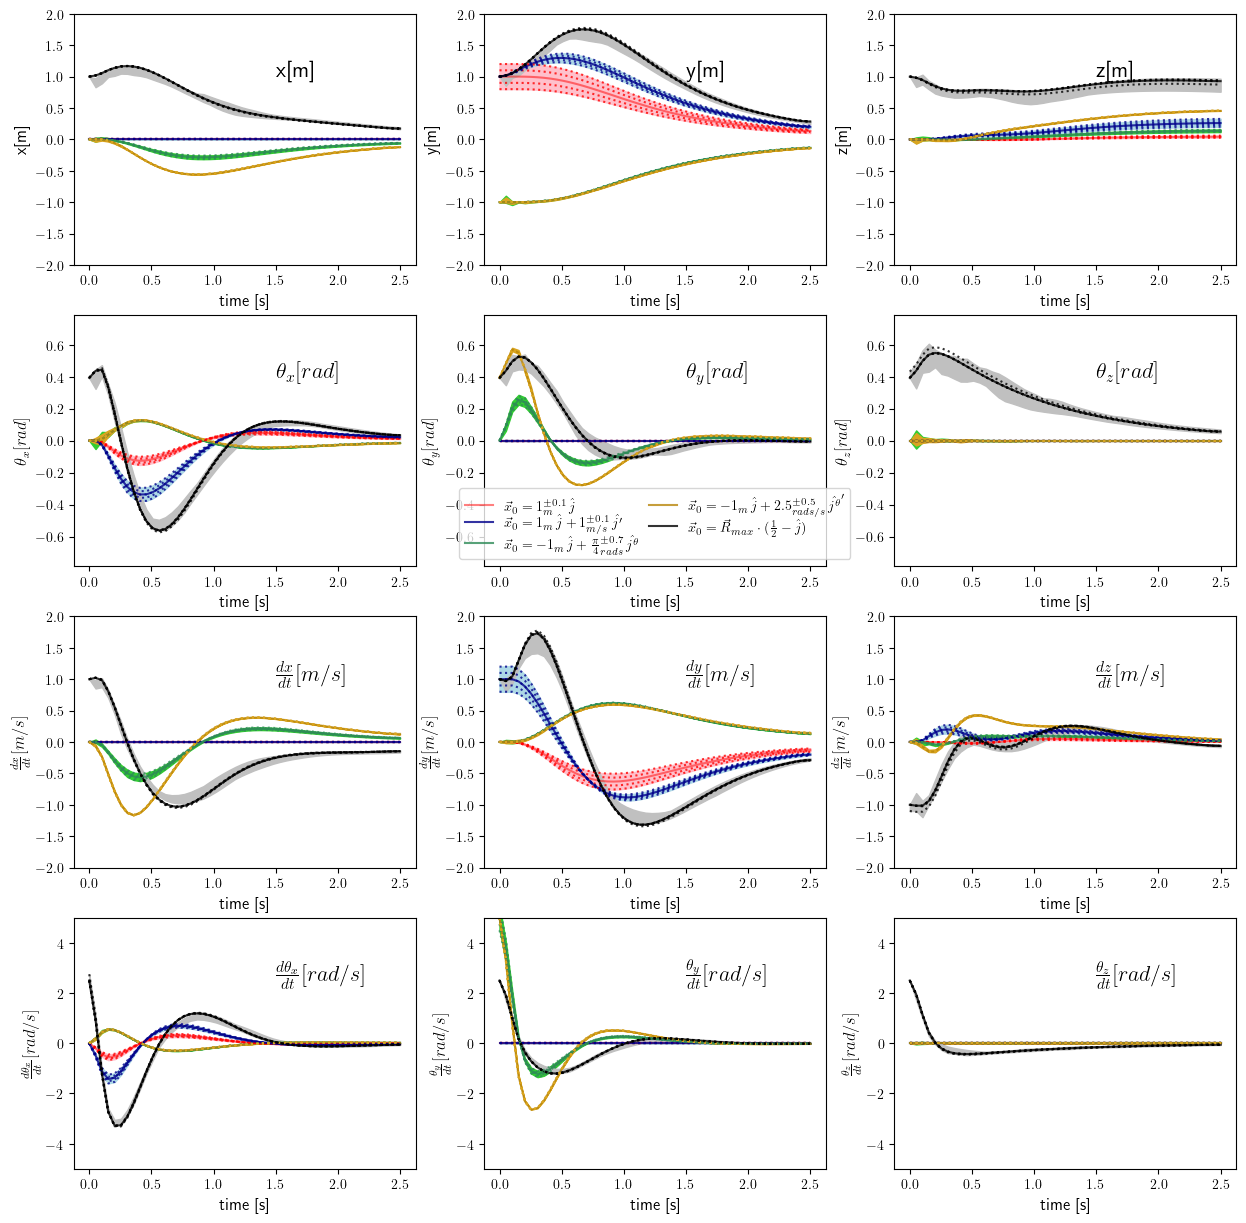

In [17]:
fig, axii = plt.subplots(4,3,figsize=(15,15))

ordered_vals = np.array([1,3,5,
                     7,9,11,
                     0,2,4,
                     6,8,10])*n_cp
ordered_labels = [r'x[m]',r'y[m]',r'z[m]',
                  r'$\theta_x [rad]$',r'$\theta_y [rad]$',r'$\theta_z [rad]$',
                  r'$\frac{dx}{dt}[m/s]$',r'$\frac{dy}{dt}[m/s]$',r'$\frac{dz}{dt}[m/s]$',
                  r'$\frac{d \theta _x}{dt} [rad/s]$',r'$\frac{ \theta _y}{dt} [rad/s]$',r'$\frac{ \theta _z}{dt} [rad/s]$']
t = np.linspace(0,time_interval,n_cp)
for enum,i in enumerate(ordered_vals):
    j=i+n_cp
    ax = axii[int(np.floor(enum/3)),int(np.floor(enum)%3)]
    #ax.plot(,'b-', alpha = 0.7);

    #filled areas
    ax.fill_between(t,np.max(mod_pred[i:j,0:5], axis=(2,1)).T,np.min(mod_pred[i:j,0:5], axis=(2,1)).T,color='pink')
    ax.fill_between(t,np.max(mod_pred[i:j,5:10], axis=(2,1)).T,np.min(mod_pred[i:j,5:10], axis=(2,1)).T,color='lightblue')
    ax.fill_between(t,np.max(mod_pred[i:j,10:15], axis=(2,1)).T,np.min(mod_pred[i:j,10:15], axis=(2,1)).T,color='limegreen')
    ax.fill_between(t,np.max(mod_pred[i:j,15:20], axis=(2,1)).T,np.min(mod_pred[i:j,15:20], axis=(2,1)).T,color='goldenrod')
    ax.fill_between(t,np.max(mod_pred[i:j,20:], axis=(2,1)).T,np.min(mod_pred[i:j,20:], axis=(2,1)).T,color='silver')

    #labled lines
    ax.plot(t, x_tot.T[0,    i:j].T,'-',alpha=0.5, color = 'red',
            label=r"$\vec{x}_0 = 1^{\pm 0.1}_{m}\,\hat{j}$");
    ax.plot(t, x_tot.T[5:6,  i:j].T,'-',alpha=0.8, color = 'darkblue', 
            label=r"$\vec{x}_0 =  1_{m}\,\hat{j} + 1^{\pm 0.1}_{m/s}\, \hat{j'}$");
    ax.plot(t, x_tot.T[10:11,i:j].T,'-',alpha=0.8, color = 'seagreen',
            label=r"$\vec{x}_0 = -1_{m}\,\hat{j} + \frac{\pi}{4}^{\pm 0.7}_{rads}\, \hat{j^{\theta}}$");
    ax.plot(t, x_tot.T[15:16,i:j].T,'-',alpha=0.8, color = 'darkgoldenrod',
            label=r"$\vec{x}_0 = -1_{m}\,\hat{j} + 2.5^{\pm 0.5}_{rads/s}\, \hat{j^{\theta}}'$");
    ax.plot(t, x_tot.T[20:21,i:j].T,'-',alpha=0.8, color = 'black', 
            label=r"$\vec{x}_0 = \vec{R}_{max}\cdot(\frac{1}{2} -\hat{j})$");

    #extra lines
    ax.plot(t, x_tot.T[1:5,  i:j].T,':', alpha=0.8, color = 'red');
    ax.plot(t, x_tot.T[5:10, i:j].T,':', alpha=0.8, color = 'darkblue');
    ax.plot(t, x_tot.T[10:15,i:j].T,':', alpha=0.8, color = 'seagreen')
    ax.plot(t, x_tot.T[15:20,i:j].T,':', alpha=0.8, color = 'goldenrod');
    ax.plot(t, x_tot.T[20:,  i:j].T,':', alpha=0.8, color = 'black');
    ax.set_ylabel(ordered_labels[enum], fontsize=12)
    ax.set_xlabel('time [s]', fontsize=12)
    if int(np.floor(enum/3)) == 0 :
        ax.set_ylim([-max_x, max_x])
        q = max_x/2
        
    if int(np.floor(enum/3)) == 1 :
        ax.set_ylim([-max_ag, max_ag])
        q = max_ag/2
        
    if int(np.floor(enum/3)) == 2 :
        ax.set_ylim([-max_dx, max_dx])
        q = max_dx/2
                    
    if int(np.floor(enum/3)) == 3 :
        ax.set_ylim([-max_da, max_da])
        q = max_da/2
                    
    ax.text(1.5,q, ordered_labels[enum], fontsize=16)
    if enum==4:
        ax.legend(loc='lower center', ncols=2,columnspacing=0.8, labelspacing=0.0)
plt.savefig(f'individal_trajectory_assessments_{mtype}.png')

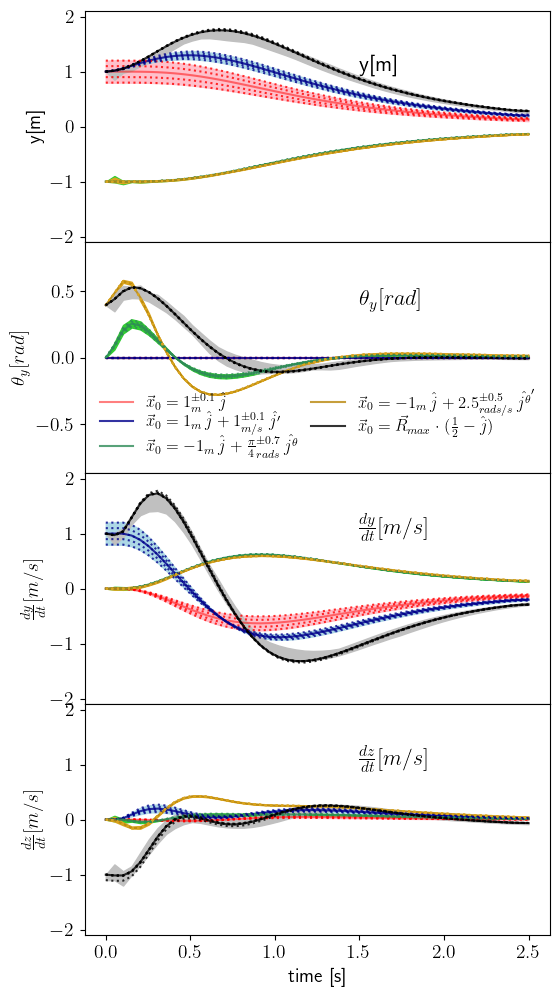

In [18]:

spec = dict(width_ratios=[1], wspace=0.0, hspace=0.0, height_ratios=[1,1,1,1])
fig, axii = plt.subplots(4,1,figsize=(6,12), sharex = True, gridspec_kw=spec)
ordered_vals = np.array([1,3,5,
                     7,9,11,
                     0,2,4,
                     6,8,10])*n_cp
ordered_labels = [r'x[m]',r'y[m]',r'z[m]',
                  r'$\theta_x [rad]$',r'$\theta_y [rad]$',r'$\theta_z [rad]$',
                  r'$\frac{dx}{dt}[m/s]$',r'$\frac{dy}{dt}[m/s]$',r'$\frac{dz}{dt}[m/s]$',
                  r'$\frac{d \theta _x}{dt} [rad/s]$',r'$\frac{ \theta _y}{dt} [rad/s]$',r'$\frac{ \theta _z}{dt} [rad/s]$']
what_to_plot = [1,4,7,8]
t = np.linspace(0,time_interval,n_cp)
ii = 0
for enum,i in enumerate(ordered_vals):
    j=i+n_cp
    if enum not in what_to_plot:
        continue
    ax = axii[ii]
    ii = ii+1
    
    #ax.plot(,'b-', alpha = 0.7);

    #filled areas
    ax.fill_between(t,np.max(mod_pred[i:j,0:5], axis=(2,1)).T,np.min(mod_pred[i:j,0:5], axis=(2,1)).T,color='pink')
    ax.fill_between(t,np.max(mod_pred[i:j,5:10], axis=(2,1)).T,np.min(mod_pred[i:j,5:10], axis=(2,1)).T,color='lightblue')
    ax.fill_between(t,np.max(mod_pred[i:j,10:15], axis=(2,1)).T,np.min(mod_pred[i:j,10:15], axis=(2,1)).T,color='limegreen')
    ax.fill_between(t,np.max(mod_pred[i:j,15:20], axis=(2,1)).T,np.min(mod_pred[i:j,15:20], axis=(2,1)).T,color='goldenrod')
    ax.fill_between(t,np.max(mod_pred[i:j,20:], axis=(2,1)).T,np.min(mod_pred[i:j,20:], axis=(2,1)).T,color='silver')

    #labled lines
    ax.plot(t, x_tot.T[0,    i:j].T,'-',alpha=0.5, color = 'red',
            label=r"$\vec{x}_0 = 1^{\pm 0.1}_{m}\,\hat{j}$");
    ax.plot(t, x_tot.T[5:6,  i:j].T,'-',alpha=0.8, color = 'darkblue', 
            label=r"$\vec{x}_0 =  1_{m}\,\hat{j} + 1^{\pm 0.1}_{m/s}\, \hat{j'}$");
    ax.plot(t, x_tot.T[10:11,i:j].T,'-',alpha=0.8, color = 'seagreen',
            label=r"$\vec{x}_0 = -1_{m}\,\hat{j} + \frac{\pi}{4}^{\pm 0.7}_{rads}\, \hat{j^{\theta}}$");
    ax.plot(t, x_tot.T[15:16,i:j].T,'-',alpha=0.8, color = 'darkgoldenrod',
            label=r"$\vec{x}_0 = -1_{m}\,\hat{j} + 2.5^{\pm 0.5}_{rads/s}\, \hat{j^{\theta}}'$");
    ax.plot(t, x_tot.T[20:21,i:j].T,'-',alpha=0.8, color = 'black', 
            label=r"$\vec{x}_0 = \vec{R}_{max}\cdot(\frac{1}{2} -\hat{j})$");

    #extra lines
    ax.plot(t, x_tot.T[1:5,  i:j].T,':', alpha=0.8, color = 'red');
    ax.plot(t, x_tot.T[5:10, i:j].T,':', alpha=0.8, color = 'darkblue');
    ax.plot(t, x_tot.T[10:15,i:j].T,':', alpha=0.8, color = 'seagreen')
    ax.plot(t, x_tot.T[15:20,i:j].T,':', alpha=0.8, color = 'goldenrod');
    ax.plot(t, x_tot.T[20:,  i:j].T,':', alpha=0.8, color = 'black');
    ax.set_ylabel(ordered_labels[enum], fontsize=14)
    ax.set_xlabel('time [s]', fontsize=14)
    ax.tick_params(axis='x', labelsize= 14)
    ax.tick_params(axis='y', labelsize= 14)
    if int(np.floor(enum/3)) == 0 :
        ax.set_ylim([-max_x*1.05, max_x*1.05])
        q = max_x/2
        
    if int(np.floor(enum/3)) == 1 :
        ax.set_ylim([-max_ag*1.1, max_ag*1.1])
        q = max_ag/2
        
    if int(np.floor(enum/3)) == 2 :
        ax.set_ylim([-max_dx*1.05, max_dx*1.05])
        q = max_dx/2
                    
    if int(np.floor(enum/3)) == 3 :
        ax.set_ylim([-max_da*1.05, max_da*1.05])
        q = max_da/2
                    
    ax.text(1.5,q, ordered_labels[enum], fontsize=16)
    if enum==4:
        ax.legend(loc='lower center', ncols=2,columnspacing=0.8, labelspacing=0.0, fontsize=12, frameon=False)
plt.savefig(f'individal_trajectory_assessments_{mtype}_select.png')

In [19]:
#
# rotational symmetry analysis
#
all_angle_diff = []
for enum, ang in enumerate(np.linspace(np.pi/8,2*np.pi-np.pi/8,85)):
    print(enum, ang, end='\r')
    ang = np.random.rand()*2*np.pi
    rf = rotate(0,0,ang)
    ri = rotate(0,0,-ang)
    rfic = rf(ic,n_cp=1)
    
    cp_pred_rot = np.stack([ri(fcnn_mods[i](torch.tensor(rfic, dtype=torch.float32)).detach().numpy()) for i in range(n_models)])
    
    diff = (cp_pred_rot-cp_pred.swapaxes(-1,1).swapaxes(0,1))
    all_angle_diff.append(diff)
all_angle_diff = np.stack(all_angle_diff)
#normalize
all_angle_diff = all_angle_diff.reshape(85,n_models,n_ic,n_dim,n_cp).swapaxes(-1,-2)/R
all_angle_diff.shape

(85, 10, 1000, 50, 12)

In [20]:
all_angle_diff_rmse = np.sqrt(np.mean(all_angle_diff**2, axis = (-1,-2)))
all_angle_diff_rmse.shape


(85, 10, 1000)

In [21]:
fig ,ax = plt.subplots(1,1, figsize=(12,5))
ax.plot(np.linspace(np.pi/8,2*np.pi-np.pi/8,85),np.mean(all_angle_diff_rmse, axis=(-1,1)),'.-')
ax.set_xticks(np.pi*np.arange(1/8,2,1/8));
ax.set_xticklabels([f"{i+1}$\pi$/8" for i in range(15)])
ax.grid()

In [22]:

spec = dict(width_ratios=[3, 1], wspace=0.05, hspace=0.05, height_ratios=[1])
fig, ax = plt.subplots(1,2,figsize=(7,5),sharey=True, gridspec_kw=spec)

for nm in range(n_models):   
    for a in range(85):  
        ax[0].plot(Ric, all_angle_diff_rmse[a,nm,:],markersize='.1',marker=a%12, 
                 linestyle='',markerfacecolor = 'k',markeredgecolor="k", alpha=.1);
ax[1].hist(all_angle_diff_rmse.flatten(), np.logspace(-5,-2,101),orientation='horizontal',density =False, color='gray');
ax[0].set_xlabel('Distance in 12-D sphere', fontsize = 12)
ax[0].set_ylabel(r'$\langle (R_z^T\mathcal{P}(R_z x_{0}) - \mathcal{P}(x_{0}))^2\rangle^{1/2}$', fontsize =12);
ax[1].set_xlabel('Counts', fontsize=12);
ax[1].set_xlabel('Counts', fontsize=12);
ax[0].set_yscale('log')
ax[0].set_ylim(0.00005,0.05)
ax[0].set_xlim(0,1.0001)
ax[0].grid()
plt.savefig(f"rotation_85_angles_ic_compare_{mtype}.png")

Error in callback <function flush_figures at 0x7f751fd28ca0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [23]:
def to_cylindrical(input_t, ncp): 
    '''
    for dx,x,dy,y,dz,z,da,a,db,b,dc,c ordered vector
    changes dx to dR
    changes x to R
    changes dy to dTheta
    changes y to theta
    
    '''
    if type(input_t) == np.ndarray:
        X = input_t.copy()
        arccos = np.arccos
        minimum = np.minimum
        abs_ = np.abs
        pi = np.pi
        zeros = np.zeros
        
    if type(input_t) == torch.Tensor:
        X = input_t.detach().clone()
        arccos = torch.arccos
        minimum = torch.minimum
        abs_ = torch.abs
        pi = torch.pi
        zeros = torch.zeros
        
    print(X.shape)
    x = X[:,ncp:2*ncp]
    y = X[:,3*ncp:4*ncp]
    
    dx = X[:,0:ncp]
    dy = X[:,2*ncp:3*ncp]
    R = np.sqrt(x**2 + y**2)
    dR = (dx*x+dy*y)/R
    
    cos_theta = x/R
    sin_theta = y/R
    q = minimum(sin_theta/abs_(sin_theta),zeros(sin_theta.shape))
    theta = -2*q*pi +arccos(cos_theta)*(1+2*q)
    dtheta = (dy*x-dx*y)/R
    
    X[:,0  :ncp]     = dR
    X[:,ncp:2*ncp]   = R
    X[:,2*ncp:3*ncp] = dtheta
    X[:,3*ncp:4*ncp] = theta
    
    return X
    

X = to_cylindrical(torch.from_numpy(cp_pred),50)

torch.Size([1000, 600, 10])


In [24]:
cp_pred[0,::50,0]

array([-0.35930383, -0.698983  ,  0.13781041,  0.40285873, -0.66402054,
       -0.4659908 ,  1.7609093 , -0.13743135,  0.31185853,  0.08579206,
       -0.9136375 ,  0.03327419], dtype=float32)

In [25]:
X[0,::50,0]

tensor([ 0.3801,  0.8068,  0.0600,  2.6187, -0.6640, -0.4660,  1.7609, -0.1374,
         0.3119,  0.0858, -0.9136,  0.0333])

In [26]:
np.sqrt(0.699**2+0.403**2)

0.8068519071056348